**Task 1**

**A**. Looking at the data set we can see that if the distance is far, the trail is never okay. It seems like "Distance-far" will be good candidate to split the tree on. After doing the calculations. we see that indeed this feature has the highest information gain at  0.1831. Therefore our first split will be on this feature.

As mentioned previously, the node with "Distance-far" contains only those trails that are not OK (T10 and T4). Therefore this is a leaf node and we do not need to split any further. Next we must calculate the information gain for all features on the other new node.

For the trails with Restriction-flat terrain , $proportion(OK)=  0.3333$ , $Entropy(p_{okay}) =  0.9183$. And for the trails that are not  Restriction-flat terrain , $proportion(OK) =  0.6667$ , $Entropy(p_{okay})= 0.9183$. And so as we can see splitting on  Restriction-flat terrain will yield the highest information gain of $0.0728$.

Now, looking at the trails that are flat, we could split on "Direction-South" , "Direction-West", "Distance-within", "Distance-short", "Type-Advanced" and "Type-Some Difficulty". But none of these splits result in a pure node. Therefore they all have identical information gains of $0.2516$. The information gain for "Some Difficulty" was calculated first. So I just chose to split on this feature value. 

After this split we have a pure node with only T8. And another node with T3 which is not Ok and T6 which is. Next if we split on either distance feature, we will end with two pure nodes. Because before the split the entropy was 1 and after the split we end with two pure leaf nodes containing only 1 trail, the information gain for this split will be 1.

Next we look at the trails that are "Restriction **not** flat". We see that for the trails with "Type-Some Difficulty", they are all OK. Therefore, $proportion(OK)=  1.0$ , $Entropy(p_{okay}) =  0$. And for the trails that are not  "Type-Some Difficulty" , $proportion(OK) =  0.5$ and $Entropy(p_okay)= 1.0$. Splitting on this feature will yield the highest information gain of  $0.2516$.

From here we will see that the information gain from any further split will be 0. This is because half of the trails in this node are OK. And splitting on any remaining feature will not result in a more pure node. 

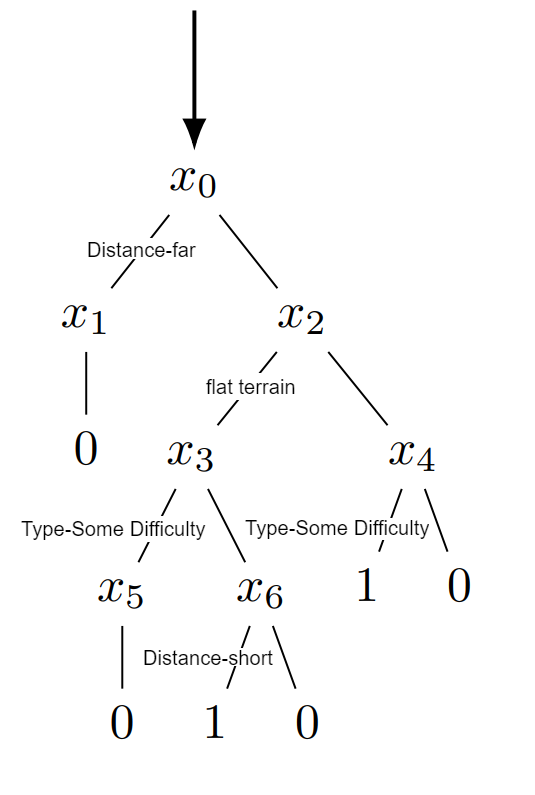

**B**. It should be noted that a conservative approach was taken to predicting the status of a trail. That is, for a given leaf, if half the training examples are **not** OK, the model is said to predict any other trail that ends up in that leaf as **not** OK also. Trails T2, T5 and T6 were correctly labelled as OK. T3,T4,T7,T8,T9,T10 were correctly labelled as **not** OK. But trails 1 and 11 were mislabeled as **not** OK. <br>
$FP =  0$ <br> 
$TN =  6$ <br>
$TP =  3$ <br>
$FN =  2$ <br>
Therefore the training set accuracy of the model on this dataset is $0.818$. <br>

**C**. The trails that were correctly identified as **not** OK are T15, T12, T13. T16 was correctly identified as OK and T14 was incorrectly labelled as **not** OK. <br>
$FP =  0$ <br> 
$TN =  3$ <br>
$TP =  1$ <br>
$FN =  1$ <br>
Therefore the training set accuracy of the model on this dataset is $0.8$. <br>

**D**. A test set error of 0.8 is not “ideal”. But it is very close to the training set error of the model. Unfortunately the model is very small and prone to mistakes. 

**Task 2** <br>
**A**.

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
mushDF = pd.read_csv('agaricus_lepiota.data', header=None)
#mushDF = pd.read_csv('even_smaller_data.txt', header=None, na_values=['?'])
mushDF.columns = ['Poisonous','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
#mushDF = mushDF.dropna()

In [3]:
def oneHotEncoder(df):
    columnsToEncode = []
    for column in df.columns:
        numUniqueVelue = df[column].nunique()
        if numUniqueVelue != 2:
            columnsToEncode.append(column)
    # Get_dummies() one-hot encodes the relavent columns
    df = pd.get_dummies(df, columns=columnsToEncode)
    return df 


mushDF = oneHotEncoder(mushDF)

In [4]:
def replaceWithBinary(df):
    for col in df.columns:
        uniqueVals = df[col].unique()
        # If this column is already a binary column, move on
        if set(uniqueVals) == set([0, 1]):
            continue
        # If there are more than two unique values, skip the column
        # For debugging
        if len(uniqueVals) > 2:
            continue
        # Create a dictionary mapping that maps the "max" letter to 1 and the "min" letter to 0
        mappingDict = {max(uniqueVals): 1, min(uniqueVals): 0}
        df[col] = df[col].replace(mappingDict)
    return df

mushDF = replaceWithBinary(mushDF)
# Turning all the data points into 1s and 0s just to make sure it's all been converted correctly one last time. 
mushDF = mushDF.astype(int)

In [5]:
# Creating training and testing sets
np.random.seed(0)
randomized_row_nums = np.random.permutation(mushDF.shape[0])
# Training set will contain 80% of the data
split_idx = int(0.7 * len(randomized_row_nums))
traning_mush_df = mushDF.iloc[randomized_row_nums[:split_idx]]
testing_mush_df = mushDF.iloc[randomized_row_nums[split_idx:]]

I needed to make sure that 0.5 is rounded up to 1. This is to make the model more conservative. I.e. if half the training examples at a given root node are 'poisonous', I wanted the predicted output for any future mushroom that ends up in that leaf to be 'poisonous'.

In [6]:
# So that 0.5 is rounded to 1, instead of the closest even integer
def my_round(x):
    EPSILON = 1e-9
    return round(x + EPSILON)

In [7]:
# This data type will represents the nodes in the tree
class DT_Node:
    def __init__(self, dataframe, feature=None, threshold=None, parent=None, left=None, right=None, depth=0):
        # The dataframe are all the mushrooms that fall under this node
        self.df = dataframe
        # This is the best feature of this node. The feature that we will split the node on
        self.feature = feature
        # When a parent node is split, all mushrooms with a 1 for that feature go to the child node
        # where threshold = 1 and all the mushrooms with a 0 for that feature go to the child node
        # with threshold = 0.
        # Note that the root node will not have a threshold because no parent
        self.threshold = threshold
        # The parent of this node. Empty for root node.
        self.parent = parent
        # The left node. Will be empty for leaf nodes
        self.left = left
        # The right node. Will be empty for leaf nodes
        self.right = right
        # The depth of this node in the tree.
        self.depth = depth
        # The proportion of mushrooms in the dataframe of this node that are poisonous
        self.probability = self.df['Poisonous'].mean()
        # If a new mushroom ends up in this node, this will determine the class lable given
        self.prediction = my_round(self.probability)

In [8]:
# Just testing the method. This tells me that most mushrooms in the dataset are not poisenous. I.e. eddible.  
root = DT_Node(mushDF)
print('The prediction for the root node is: ', root.prediction)

The prediction for the root node is:  0


In [9]:
def entropy_calculator(node):
    df = node.df
    n_positive = (df['Poisonous'] == 1).sum()
    n_total = df.shape[0]
    p_positive = n_positive/n_total
    p_negative = 1-p_positive
    if (p_positive == 0 or p_positive == 1):
        return 0
    entropy = -p_positive*math.log2(p_positive) - \
        p_negative*math.log2(p_negative)
    return entropy

# Again, checking to see if the method works properly. This tells me that I have a balance sample of 'poisenous' and 'edible' mushrooms.
print('Entropy of the root node is: ', entropy_calculator(root))

Entropy of the root node is:  0.9990678968724604


In [10]:
def split(node, column):
    # Column is None when there is no best feature to split on.
    if column == None:
        return
    df = node.df
    left_df = df[df[column] == 1]
    right_df = df[df[column] == 0]
    # If you've already split on this feature, just return
    if right_df.shape[0] == 0 or left_df.shape[0] == 0:
        return
    left_node = DT_Node(dataframe=left_df, threshold=1,
                        parent=node, depth=node.depth+1)
    right_node = DT_Node(dataframe=right_df, threshold=0,
                         parent=node, depth=node.depth+1)
    node.left = left_node
    node.right = right_node
    return left_node, right_node


In [11]:
def fetch_best_feature(node):
    if (node == None):
        return
    best_feature = None
    df = node.df
    n_total = df.shape[0]
    curent_entropy = entropy_calculator(node)
    max_information_gain = 0
    # for debugging
    infGains = []
    for column in df.columns:
        # dont ever split on the response
        if column == 'Poisonous':
            continue
        split_result = split(node, column)
        # If you've already split on that feature skip
        if split_result is None:
            continue
        left_node, right_node = split_result
        n_yes = left_node.df.shape[0]
        n_no = right_node.df.shape[0]
        wL = n_yes/n_total
        wR = n_no/n_total
        information_gain = curent_entropy - wL * \
            entropy_calculator(left_node) - wR*entropy_calculator(right_node)
        infGains.append(information_gain)
        if information_gain > max_information_gain:
            max_information_gain = information_gain
            best_feature = column
    node.feature = best_feature
    return best_feature

**B**. Here I implement stopping_depth.

In [12]:
def train_tree(node, stopping_depth=1):
    if node.depth >= stopping_depth:
        return
    feature = fetch_best_feature(node)
    split_result = split(node, feature)
    if split_result is None or feature == None:
        return
    left_node, right_node = split_result
    train_tree(left_node, stopping_depth)
    train_tree(right_node, stopping_depth)
    return node

In [13]:
other_root = DT_Node(traning_mush_df)
tree = train_tree(other_root, 2)

In [14]:
def print_tree(node, indent=''):
    poison_status = ""
    prediction = ""
    if node == None:
        return
    if node.feature == None:
        prediction = ", Prediction:"
        if node.prediction == 0:
            poison_status = 'Edible'
        else:
            poison_status = 'Poisenous'
    print(indent + ' | Depth:', node.depth, prediction, poison_status)
    if node.feature == None:
        return
    print(indent + node.feature, 'yes:')
    print_tree(node.left, indent + '  ')
    print(indent + node.feature, 'no:')
    print_tree(node.right, indent + '  ')

This is the printed tree for a tree of depth 2.

In [15]:
print_tree(tree)

 | Depth: 0  
odor_n yes:
   | Depth: 1  
  spore-print-color_r yes:
     | Depth: 2 , Prediction: Poisenous
  spore-print-color_r no:
     | Depth: 2 , Prediction: Edible
odor_n no:
   | Depth: 1  
  bruises yes:
     | Depth: 2 , Prediction: Edible
  bruises no:
     | Depth: 2 , Prediction: Poisenous


**B**. This is the printed tree for a tree of depth 3

In [16]:
root = DT_Node(traning_mush_df)
tree = train_tree(root, 3)
print_tree(tree)

 | Depth: 0  
odor_n yes:
   | Depth: 1  
  spore-print-color_r yes:
     | Depth: 2 , Prediction: Poisenous
  spore-print-color_r no:
     | Depth: 2  
    stalk-surface-below-ring_y yes:
       | Depth: 3 , Prediction: Poisenous
    stalk-surface-below-ring_y no:
       | Depth: 3 , Prediction: Edible
odor_n no:
   | Depth: 1  
  bruises yes:
     | Depth: 2  
    stalk-root_c yes:
       | Depth: 3 , Prediction: Edible
    stalk-root_c no:
       | Depth: 3 , Prediction: Poisenous
  bruises no:
     | Depth: 2 , Prediction: Poisenous


**B**. This is the printed tree for a tree of depth 4.

In [17]:
root = DT_Node(traning_mush_df)
tree = train_tree(root, 4)
print_tree(tree)

 | Depth: 0  
odor_n yes:
   | Depth: 1  
  spore-print-color_r yes:
     | Depth: 2 , Prediction: Poisenous
  spore-print-color_r no:
     | Depth: 2  
    stalk-surface-below-ring_y yes:
       | Depth: 3  
      gill-size yes:
         | Depth: 4 , Prediction: Poisenous
      gill-size no:
         | Depth: 4 , Prediction: Edible
    stalk-surface-below-ring_y no:
       | Depth: 3  
      cap-surface_g yes:
         | Depth: 4 , Prediction: Poisenous
      cap-surface_g no:
         | Depth: 4 , Prediction: Edible
odor_n no:
   | Depth: 1  
  bruises yes:
     | Depth: 2  
    stalk-root_c yes:
       | Depth: 3 , Prediction: Edible
    stalk-root_c no:
       | Depth: 3  
      stalk-root_r yes:
         | Depth: 4 , Prediction: Edible
      stalk-root_r no:
         | Depth: 4 , Prediction: Poisenous
  bruises no:
     | Depth: 2 , Prediction: Poisenous


**C**. Here I implemet a test procedure. Calculating percision, accuracy, recall and F scores. 
In addition I also make a ROC from my training scores. 

In [18]:
# Tell me if this mushroom is poisonous or not
def predict(node, x):
    # If the feature that a node will be split on is 'None', then we are at a leaf node.
    # Threfore simply read off the prediction
    if node.feature == None:
        pred = node.prediction
    else:
        if x[node.feature] == 1:
            pred = predict(node.left, x)
        else:
            pred = predict(node.right, x)
    return pred

In [19]:
# Tell me if these mushrooms are poisonous or not
def make_predictions(tree, df):
    preds = []
    for i in range(df.shape[0]):
        x = df.iloc[i]
        pred = predict(tree, x)
        preds.append(pred)
    preds = np.array(preds)
    return preds

In [20]:
# Will be used to calculate evaluation measures and make ROC
def calculate_scores(y, y_hat):
    vec = y - 2*y_hat
    tp = np.count_nonzero(vec == -1)
    tn = np.count_nonzero(vec == 0)
    fp = np.count_nonzero(vec == -2)
    fn = np.count_nonzero(vec == 1)
    return tp, tn, fp, fn

In [21]:
# Calculates accuracy, percision and recal from scores
def calculate_performance(df, y_hat):
    y_true = df['Poisonous'].to_numpy()
    tp, tn, fp, fn = calculate_scores(y_true, y_hat)
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1Score = (2*prec*rec)/(prec+rec)
    return acc, prec, rec, f1Score

**D**. Here I propose and implement an evaluation method for my DecisionTree algorithm. I will check the depth parameter to see which produces a better result on the training data. I will also plot an ROC to decide what cutoff score I should use. Currently if the predicted probability of being poisonous is at or above 0.5, the sample is considered to be poisonous. But it is important to consider whether this is a proper cutoff score for this task.<br>
In reality of course if one was to use this model to determine whether mushrooms were fit for consumption, the cost of mislabeling a poisonous mushroom as edible is much too high and one might want to pair this approach with cross validation and expected utility calculations to determine the most appropriate threshold.<br>
I would personally not be happy with a cutoff score of 0.5 in the real world. But in my opinion, for the purposes of demonstrating my understanding of the tasks in this assignment, it is not a bad starting point.<br>
I will be creating an ROC plot as a visual demonstration of the performance of my model on the training set. I will also calculate performance measures (using the training set) on different depths of my tree and comparing the output.<br>
Finally I will calculate the same measures on the testing set. This should give me an idea of the performance of my model on new data in general while also giving me some insight into potential problems with overfitting.

In [22]:
# Probability that this mushroom is poisenous.
def give_prob(node, x):
    # If the feature that a node will be split on is 'None', then we are at a leaf node.
    # Threfore simply read off the probability
    if node.feature == None:
        prob = node.probability
    else:
        if x[node.feature] == 1:
            prob = give_prob(node.left, x)
        else:
            prob = give_prob(node.right, x)
    return prob

In [23]:
# Probabilities of these mushrooms being poisonous
def give_probabilities(tree, df):
    probs = []
    for i in range(df.shape[0]):
        x = df.iloc[i]
        prob = give_prob(tree, x)
        probs.append(prob)
    probs = np.array(probs)
    return probs


In [24]:
# Calculate TPR and FPR
def calculate_rates(df, p_hat, threshold):
    # If the value is higher than the threshold, mark it as a positive, i.e. poisonous.
    # Else mark it as 0 i.e. eddible.
    new_p_hat = np.where(p_hat > threshold, 1, 0)
    y_true = df['Poisonous'].astype(int).to_numpy()
    tp, tn, fp, fn = calculate_scores(y_true, new_p_hat)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

In [25]:
# Draw me a ROC curve
def draw_roc_curve(df, p_hat, num_thresholds=1000):
    thresholds = np.linspace(0, 1, num_thresholds)
    tprs = []
    fprs = []
    for threshold in thresholds:
        tpr, fpr = calculate_rates(df, p_hat, threshold)
        tprs.append(tpr)
        fprs.append(fpr)

    plt.plot(fprs, tprs)
    plt.title('ROC Curve for training set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    # For debugging
    return tprs, fprs

In [26]:
tree = train_tree(root, 2)
pred = make_predictions(tree, traning_mush_df)
Accuracy, Percision, Recall, f1_score = calculate_performance(traning_mush_df, pred)
print('The Accuracy of the model on the training data is : ', Accuracy)
print('The percision of the model on the training data is :', Percision)
print('The Recal of the model on the training data is :', Recall)
print('The F - Score of the model on this data is :', f1_score)

The Accuracy of the model on the training data is :  0.9301793879704537
The percision of the model on the training data is : 1.0
The Recal of the model on the training data is : 0.8539367181751287
The F - Score of the model on this data is : 0.9212145266918039


In [27]:
tree = train_tree(root, 3)
pred = make_predictions(tree, traning_mush_df)
Accuracy, Percision, Recall, f1_score = calculate_performance(traning_mush_df, pred)
print('The Accuracy of the model on the training data is : ', Accuracy)
print('The percision of the model on the training data is :', Percision)
print('The Recal of the model on the training data is :', Recall)
print('The F - Score of the model on this data is :', f1_score)

The Accuracy of the model on the training data is :  0.9614843475202252
The percision of the model on the training data is : 0.9271794871794872
The Recal of the model on the training data is : 0.9977924944812362
The F - Score of the model on this data is : 0.961190855927698


In [28]:
tree = train_tree(root, 4)
pred = make_predictions(tree, traning_mush_df)
Accuracy, Percision, Recall, f1_score = calculate_performance(traning_mush_df, pred)
print('The Accuracy of the model on the training data is : ', Accuracy)
print('The percision of the model on the training data is :', Percision)
print('The Recal of the model on the training data is :', Recall)
print('The F - Score of the model on this data is :', f1_score)

The Accuracy of the model on the training data is :  0.9871614491734084
The percision of the model on the training data is : 0.9748653500897666
The Recal of the model on the training data is : 0.9988962472406181
The F - Score of the model on this data is : 0.9867345084499364


As we can see the deeper models perform better on most measures. It is interesting that the model percision dips from $1$ to around $0.93$ and then rises back up to $0.97$. Because of its higher performance on most measures, I will be choosing the deeper tree of depth $4$.

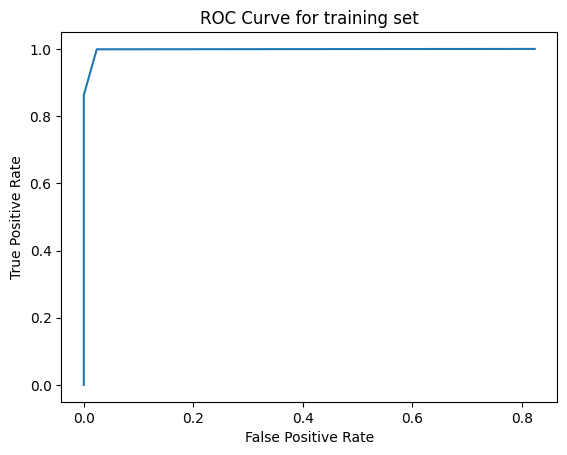

In [29]:
p_pred = give_probabilities(tree, traning_mush_df)
tprs, fprs = draw_roc_curve(traning_mush_df, p_pred)

As we can see from the curve above, there is quite a large amount of area under the ROC curve. This is expected given the high prformance of the model on the data set.  

In [30]:
pred = make_predictions(tree, testing_mush_df)
Accuracy, Percision, Recall, f1_score = calculate_performance(testing_mush_df, pred)
print('The Accuracy of the model on the test data is : ', Accuracy)
print('The percision of the model on the test data is :', Percision)
print('The Recal of the model on the test data is :', Recall)
print('The F - Score of the model on the test data is :', f1_score)

The Accuracy of the model on the test data is :  0.9889253486464314
The percision of the model on the test data is : 0.9787408013082584
The Recal of the model on the test data is : 0.9991652754590985
The F - Score of the model on the test data is : 0.9888475836431226


**Task 3**. <br>
**A**. Changing the splitting criterion is very likely to change the arrangement of the nodes, and therefore the predictions made by the tree algorithm. For example, if I choose to split the nodes based on alphabetical order of the name of each feature, then not only would my current decision tree look very different, i.e. splitting first on ‘bruises?’, then ‘cap-colour’, then ‘cap-shape’ etc. This is likely to produce an incredibly biassed model which is incredibly sensitive to the labels of the features.
Common decision tree based methods have been shown to be somewhat sensitive to the order in which features are presented to the algorithm. Sometimes producing highly unexpected, biassed models*. This implementation will make this particular problem much, much worse.<br>  
*Au, Timothy. (2017). Random Forests, Decision Trees, and Categorical Predictors: The "Absent Levels" Problem. Journal of Machine Learning Research. 19.<br>
**B**. It provides a measure of overfitting by the comparison of test set performance with training set performance. If test set performance was much worse (which it is not) one could say that the model has sacrificed generalizability of predictions for performance on the training set. <br>
On the other hand underfitting can be gauged by comparing performance of the tree on the training set across different depths. For this very reason a hyperparameter depth of $4$ was chosen to increase the feature learning capability of the model. 